In [1]:
import boto3
import os
from dotenv import load_dotenv
# Connect to s3
load_dotenv()
 
s3 = boto3.client(
"s3",
aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
region_name=os.getenv("AWS_DEFAULT_REGION")
)

In [2]:
import pandas as pd 

manga_df = pd.read_parquet("../data/cleaned/cleaned_manga_metadata.parquet")

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd 


def parse_release_year(start_date):
    """Extract release year from startDate"""
    if pd.notna(start_date):
        return start_date.year
    return np.nan

def one_hot_encode_column(df, col):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[col])
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    return df.join(encoded_df)


def create_manga_features(data):
    df = pd.read_parquet(data)

    # Drop these for now
    df = df.drop(columns=['title', 'volumes', 'description', 'favourites', 'meanScore'])
    
    # Extract release year
    df['release_year'] = df['startDate'].apply(parse_release_year)
    df = df.drop(columns=['startDate'])

    df = df.dropna()

    # One hot encode tags
    df_encoded = one_hot_encode_column(df, 'tags')
    df_encoded = df_encoded.drop(columns=['tags'])

    # One hot encode genres
    df_encoded = one_hot_encode_column(df_encoded, 'genres')
    df_encoded = df_encoded.drop(columns=['genres'])

    # Convert bool to numeric
    df_encoded['isAdult'] = df_encoded['isAdult'].astype(int)

    # Log transform
    df_encoded['popularity'] = np.log1p(df_encoded['popularity'])
    df_encoded['chapters'] = np.log1p(df_encoded['chapters'].replace(-1, 0))  # Replace -1 with 0 before log

    # Standardize numerical features
    scaler = StandardScaler()
    num_cols = ['popularity', 'chapters', 'averageScore', 'release_year']
    df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

    return df_encoded

In [4]:
test = create_manga_features("../data/cleaned/cleaned_manga_metadata.parquet")

In [5]:
test    

,popularity,chapters,averageScore,isAdult,id,has_end_date,release_year,4-koma,achromatic,achronological order,...,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,2.365659,0.974305,2.726926,0,30001,1,-2.204892,0,0,1,...,0,0,1,1,0,0,0,0,0,1
1,3.624993,-1.198447,3.149549,0,30002,0,-2.774917,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,2.358061,1.156746,2.092991,0,30003,1,-1.634867,0,0,1,...,0,0,1,1,0,1,0,0,0,1
3,0.756273,0.924391,1.670368,0,30004,1,-2.204892,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0.675697,-1.198447,1.881680,0,30007,0,-2.774917,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.899350,-1.198447,-0.865371,0,180890,0,1.215259,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,-0.905228,-1.198447,0.402498,0,180891,0,1.215259,0,0,0,...,0,0,0,0,0,0,0,0,0,0
864,-0.449699,-1.198447,0.402498,0,182066,0,1.215259,0,0,0,...,0,0,0,0,0,0,0,0,0,0
865,-0.923658,-1.198447,1.670368,0,187944,0,1.215259,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

test = test.drop(columns=['id'])
cos_sim_matrix = cosine_similarity(test.values)
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=test.index, columns=test.index)
print(cos_sim_df)

          0         1         2         3         4         5         6    \
0    1.000000  0.507421  0.662847  0.413084  0.418077  0.274046  0.387626   
1    0.507421  1.000000  0.460328  0.325421  0.463229  0.290806  0.270126   
2    0.662847  0.460328  1.000000  0.459719  0.322611  0.311204  0.320937   
3    0.413084  0.325421  0.459719  1.000000  0.322598  0.230515  0.322884   
4    0.418077  0.463229  0.322611  0.322598  1.000000  0.235207  0.268536   
..        ...       ...       ...       ...       ...       ...       ...   
862 -0.267781 -0.075604 -0.219627 -0.270265 -0.109613  0.007442 -0.122767   
863 -0.135549  0.075315 -0.088585 -0.165709  0.010100  0.028244 -0.068659   
864 -0.099969  0.168779 -0.087842 -0.153698  0.025420  0.064390 -0.021048   
865  0.017843  0.072014 -0.001793 -0.029731  0.169048  0.088997  0.025609   
866 -0.245695 -0.042261 -0.101379 -0.177144 -0.076693 -0.005867  0.008274   

          7         8         9    ...       857       858       859  \
0  

In [7]:
top_n = 2  # Number of top similar rows (excluding self)

top_similar = {}
for idx in cos_sim_df.index:
    # Sort other rows by similarity (descending), exclude self
    similar_idxs = cos_sim_df.loc[idx].drop(idx).sort_values(ascending=False).head(top_n).index.tolist()
    top_similar[idx] = similar_idxs

print(top_similar)


{0: [2, 15], 1: [63, 215], 2: [0, 85], 3: [56, 36], 4: [66, 111], 5: [129, 10], 6: [51, 174], 7: [8, 25], 8: [7, 126], 9: [20, 1], 10: [89, 74], 11: [292, 10], 12: [28, 52], 13: [60, 54], 14: [26, 95], 15: [0, 85], 16: [119, 92], 17: [88, 28], 18: [1, 9], 19: [122, 31], 20: [9, 19], 21: [140, 110], 22: [24, 429], 23: [135, 24], 24: [156, 60], 25: [119, 7], 26: [175, 14], 27: [2, 176], 28: [52, 199], 29: [126, 30], 30: [32, 117], 31: [245, 111], 32: [174, 100], 33: [89, 10], 34: [392, 743], 35: [52, 71], 36: [37, 3], 37: [353, 258], 38: [39, 68], 39: [231, 31], 40: [330, 571], 41: [24, 22], 42: [153, 101], 43: [106, 79], 44: [26, 255], 45: [87, 75], 46: [119, 117], 47: [31, 164], 48: [399, 88], 49: [92, 177], 50: [70, 126], 51: [6, 56], 52: [28, 163], 53: [94, 242], 54: [13, 102], 55: [535, 187], 56: [196, 50], 57: [50, 43], 58: [107, 215], 59: [131, 338], 60: [189, 156], 61: [10, 509], 62: [13, 24], 63: [1, 65], 64: [108, 116], 65: [201, 1], 66: [4, 31], 67: [92, 16], 68: [121, 99], 69

In [29]:
user_df = pd.read_parquet("../data/cleaned/cleaned_user_readdata.parquet")

In [30]:
user_df.head()

,mediaId,userId,progress,progressVolumes,score,priority,private,repeat,status,name
0,30698,1,40,6,3,0,False,0,PAUSED,Josh
1,33500,1,7,1,1,0,False,0,PAUSED,Josh
2,35178,1,6,0,2,0,False,0,PAUSED,Josh
3,31158,1,0,0,0,0,False,0,PLANNING,Josh
4,53390,1,64,10,2,0,False,0,DROPPED,Josh


In [17]:
user_df['status'].value_counts()

status
PLANNING     2786
CURRENT      2786
COMPLETED    2189
PAUSED       1592
DROPPED       597
Name: count, dtype: int64

In [19]:
user_df['score'].value_counts()

score
0     4378
8     1592
9     1393
2      796
10     597
7      398
1      398
3      199
6      199
Name: count, dtype: int64

In [21]:
status_map = {
    "COMPLETED": 1.0,
    "READING": 0.8,
    "CURRENT": 0.8,
    "PLANNING": 0.4,
    "DROPPED": 0.1
}

user_df['weight'] = user_df['status'].map(status_map)

user_df['test_score'] = user_df['weight'] * (user_df['score'] / 10)

<Axes: >

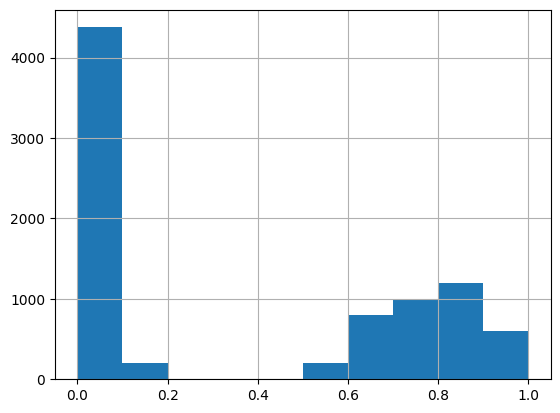

In [22]:
user_df['test_score'].hist()

<Axes: >

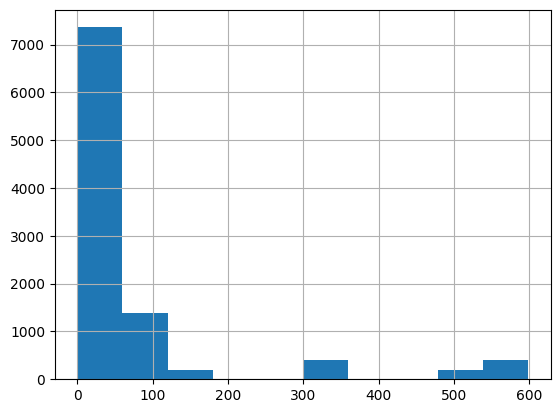

In [13]:
import matplotlib.pyplot as plt

user_df['progress'].hist()

In [15]:
user_df['progress'].describe()

count    9950.000000
mean       71.040000
std       141.424639
min         0.000000
25%         0.000000
50%        18.500000
75%        63.000000
max       599.000000
Name: progress, dtype: float64

In [31]:
user_df

,mediaId,userId,progress,progressVolumes,score,priority,private,repeat,status,name
0,30698,1,40,6,3,0,False,0,PAUSED,Josh
1,33500,1,7,1,1,0,False,0,PAUSED,Josh
2,35178,1,6,0,2,0,False,0,PAUSED,Josh
3,31158,1,0,0,0,0,False,0,PLANNING,Josh
4,53390,1,64,10,2,0,False,0,DROPPED,Josh
...,...,...,...,...,...,...,...,...,...,...
9945,76282,30,0,0,0,0,False,0,PLANNING,JasperKazai
9946,54172,36,1,0,8,0,False,0,COMPLETED,flap
9947,34632,36,0,0,0,0,False,0,PAUSED,flap
9948,44110,36,0,0,0,0,False,0,CURRENT,flap


In [36]:
user_df['status'].value_counts()

status
PLANNING     2786
CURRENT      2786
COMPLETED    2189
PAUSED       1592
DROPPED       597
Name: count, dtype: int64

In [45]:
def create_user_features(data):
    # Accept either a path-like object or a DataFrame
    if isinstance(data, (str, Path)):
        df = pd.read_parquet(data)
    elif isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        df = pd.read_parquet(data)

    # Drop unused columns (assign the result)
    df = df.drop(columns=['priority', 'progress', 'progressVolumes', 'private', 'repeat', 'name'], errors='ignore')
    
    # Map status to numerical representation
    status_map = {
        "COMPLETED": 1.0,
        "CURRENT": 0.8,
        "PAUSED": 0.5,
        "PLANNING": 0.2,
        "DROPPED": 0.1
    }
    
    df['status'] = df['status'].map(status_map)

    df['interaction_strength'] = df['status'] * (df['score'] / 10)
    
    return df

In [46]:
from pathlib import Path
test = create_user_features(user_df)

<Axes: >

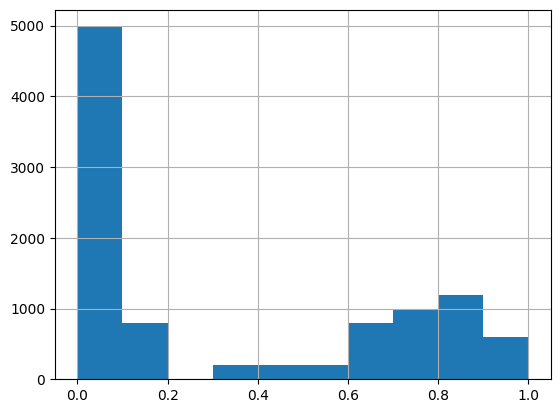

In [47]:
test['interaction_strength'].hist()

In [48]:
df = pd.read_parquet('../data/features/user_features.parquet')